In [1]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import widgets

### API Key and Example Origin Destination pair

In [2]:
# HERE Maps API credentials
HERE_API_KEY = "_ndbqeeFBj4CO61Ygrbm0duIGwVPbWIm6Mp8_GvgD9A"

# Example usage
origin = "45.77031773045832,4.797116290985852"
destination = "45.76469668270752,4.955347272776582"

### Vechile Parameters

In [3]:
vehicle_params = {
    "mass": 1190,  # kg
    "wheel_radius": 0.2848,  # meters
    "transmission_ratio": 5.763,
    "transmission_efficiency": 0.95,
    "drive_efficiency": 0.85,
    "a0": 125.73,  # N
    "a1": 1.72,  # N/(m/s)
    "a2": 0.58,  # N/(m/s)^2
    "motor_min_torque": -50,  # Nm
    "motor_max_torque": 200,  # Nm
    "acceleration": 1.5,  # m/s²
    "air_density": 1.225  # kg/m^3
}

### Retriving routing data from API

In [4]:
def get_route_data(origin, destination, routing_mode):
    url = "https://router.hereapi.com/v8/routes"
    params = {
        "apikey": HERE_API_KEY,
        "transportMode": "car",
        "origin": origin,
        "destination": destination,
        "routingMode": routing_mode,  # Specify routing mode
        "return": "summary,polyline"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        raise Exception(f"HERE Maps API request failed with status code {response.status_code}")

# Data for the sample origin destination pair:
fastest_route = get_route_data(origin, destination, routing_mode="fast")
shortest_route = get_route_data(origin, destination, routing_mode="short")

In [5]:
print(fastest_route)

{'routes': [{'id': '980f9aa6-dd4b-462f-a722-4890b4fc7b30', 'sections': [{'id': '75e86f1a-4c86-4fdb-bf6b-f07967bb2263', 'type': 'vehicle', 'departure': {'time': '2025-03-01T11:53:29+01:00', 'place': {'type': 'place', 'location': {'lat': 45.7703299, 'lng': 4.79704}, 'originalLocation': {'lat': 45.7703177, 'lng': 4.7971162}}}, 'arrival': {'time': '2025-03-01T12:17:05+01:00', 'place': {'type': 'place', 'location': {'lat': 45.7647268, 'lng': 4.956095}, 'originalLocation': {'lat': 45.7646966, 'lng': 4.9553472}}}, 'summary': {'duration': 1416, 'length': 16897, 'baseDuration': 1240}, 'polyline': 'BG0lzp3Cgn5kJkcnQoVvM4SnLgjBrT0hCriB4S_J4SzK0oB3XkSzKkSzKoGrE8GnGkD4D8GkIoG8G0KwM0PkSwHsJgKwMoL4SwCsE8GwR8BsJoBoLU8Q0PoL0FkD46BgZ8V0KoLoLgZ8f84B0rCoVkhBwWkhB8QoV0U7LgPvHkD7BkIjDkN7B0FT4NU8aoG0Z4c4c0jB8G8G8G8L0K4SoQge4IsO4SgZ8GsJoG8GwH8GsOoL0KwHgmCssB0P0K8QwM0Z0UgP4NkrBkwBkXof8L4S8G0KkDgFoQkcoQgjBoQ8kBsO0oBgUo9BgUghCwC8GoLgjB8QkrBoLwb0FsOkSwlBgtBs5Cof4pCkSgyBoQg3B8QghCgKgyBkIgyB0FssBkDkhBkD8uBkDs2BTgtB

## Main Energy Consumption Model Based on [G. De Nunzio, L. Thibault and A. Sciarretta, "A model-based eco-routing strategy for electric vehicles in large urban networks," 2016 IEEE 19th International Conference on Intelligent Transportation Systems (ITSC), Rio de Janeiro, Brazil, 2016, pp. 2301-2306, doi: 10.1109/ITSC.2016.7795927.](https://ieeexplore.ieee.org/document/7795927)

In [6]:
from geopy.distance import geodesic

def compute_energy_consumption(route_sections, vehicle_params):
    energy_consumption = []
    gravity = 9.81  # m/s²
    def compute_section_energy(length, speed, grade, acceleration=0):
        rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
        slope_force = vehicle_params["mass"] * gravity * grade
        inertial_force = vehicle_params["mass"] * acceleration

        # Total force at wheels
        total_force = rolling_force + slope_force + inertial_force

        # Motor torque and power
        wheel_radius = vehicle_params["wheel_radius"]
        transmission_ratio = vehicle_params["transmission_ratio"]
        transmission_efficiency = vehicle_params["transmission_efficiency"]

        if total_force >= 0:
            motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
        else:
            motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio

        motor_speed = speed * transmission_ratio / wheel_radius
        motor_power = motor_torque * motor_speed

        # Battery power demand considering efficiency
        drive_efficiency = vehicle_params["drive_efficiency"]
        if motor_power >= 0:
            battery_power = motor_power / drive_efficiency
        else:
            battery_power = motor_power * drive_efficiency

        # Energy for this section (Wh)
        travel_time = length / speed if speed > 0 else 0
        energy = (battery_power * travel_time) / 3600
        return energy

    if all(isinstance(section, tuple) for section in route_sections):
        for i in range(len(route_sections) - 1):
            start_coord = route_sections[i]
            end_coord = route_sections[i + 1]

            length = geodesic(start_coord, end_coord).meters
            speed = 10  # Assume constant speed (10 m/s ~ 36 km/h)
            grade = 0  # Flat terrain assumption

            # Energy computation
            energy = compute_section_energy(length, speed, grade)
            energy_consumption.append(energy)
    else:
        for section in route_sections:
            length = section["summary"]["length"]
            duration = section["summary"]["duration"]
            speed = length / duration if duration > 0 else 0
            grade = section.get("grade", 0)
            acceleration = section.get("acceleration", 0)

            # Energy computation
            energy = compute_section_energy(length, speed, grade, acceleration)
            energy_consumption.append(energy)

    return energy_consumption

### Finding closest node in the graph for the given geo co-ordinates

In [7]:
def find_closest_node(graph, target_coords):
    closest_node = None
    min_distance = float('inf')

    for node in graph.nodes:
        # Calculate the geodesic distance between the node and target coordinates
        distance = geodesic(node, target_coords).meters
        if distance < min_distance:
            min_distance = distance
            closest_node = node

    return closest_node


### Computing route energy and conversion into relevant metrics

In [8]:
def compute_route_energy(route_sections, vehicle_params):
    energy_joules = compute_energy_consumption(route_sections, vehicle_params)
    energy_kwh = [energy / 3_600_000 for energy in energy_joules]  # Convert Joules to kWh
    return energy_kwh

## Rebuilding the graph where weights of the path are based on the energy consumption for that section

In [33]:
import networkx as nx

def rebuild_graph_from_route_sections(route_sections, vehicle_params):
    new_graph = nx.DiGraph()

    # Compute energy consumption for each section
    energy_values = compute_energy_consumption(route_sections, vehicle_params)

    for i, section in enumerate(route_sections):
        try:
            start = (
                section["departure"]["place"]["location"]["lat"],
                section["departure"]["place"]["location"]["lng"]
            )
            end = (
                section["arrival"]["place"]["location"]["lat"],
                section["arrival"]["place"]["location"]["lng"]
            )

            # Use computed energy as the weight
            weight = energy_values[i] if i < len(energy_values) else INT_MAX

            # Add edge to the graph with energy as weight
            new_graph.add_edge(start, end, weight=weight)
        except KeyError as e:
            print(f"Error processing section: {e}")

    return new_graph


### Comparing results for the sample Origin Destination Pair

In [34]:
def compare_routes(origin, destination, vehicle_params):
    print(f"Comparing routes from Origin: {origin} to Destination: {destination}")

    try:
        # Fetch fastest route data
        fastest_route = get_route_data(origin, destination, routing_mode="fast")
        fastest_energy = compute_route_energy(fastest_route["routes"][0]["sections"], vehicle_params)

        # Fetch shortest route data
        shortest_route = get_route_data(origin, destination, routing_mode="short")
        shortest_energy = compute_route_energy(shortest_route["routes"][0]["sections"], vehicle_params)

        # Rebuild the graph using shortest route data
        road_network = rebuild_graph_from_route_sections(shortest_route["routes"][0]["sections"],vehicle_params)

        # Find the custom route using the rebuilt graph
        origin_coords = tuple(map(float, origin.split(",")))
        destination_coords = tuple(map(float, destination.split(",")))
        origin_node = find_closest_node(road_network, origin_coords)
        destination_node = find_closest_node(road_network, destination_coords)

        custom_route_coords = nx.bellman_ford_path(road_network, source=origin_node, target=destination_node, weight="weight") #bellman_ford_algo
        custom_energy = compute_route_energy(custom_route_coords, vehicle_params)

        # Summarize energy consumption
        energy_comparison = {
            "Fastest Route Energy (kWh)": sum(fastest_energy),
            "Shortest Route Energy (kWh)": sum(shortest_energy),
            "Custom Route Energy (kWh)": sum(custom_energy),
        }

        # Calculate percentage savings for the custom route
        energy_comparison["Savings Compared to Fastest (%)"] = (
            (1 - energy_comparison["Custom Route Energy (kWh)"] / energy_comparison["Fastest Route Energy (kWh)"]) * 100
        )
        energy_comparison["Savings Compared to Shortest (%)"] = (
            (1 - energy_comparison["Custom Route Energy (kWh)"] / energy_comparison["Shortest Route Energy (kWh)"]) * 100
        )

        return energy_comparison

    except Exception as e:
        print(f"Error comparing routes: {e}")
        return None


In [35]:
comparison_results = compare_routes(origin, destination,vehicle_params)
print(comparison_results)

Comparing routes from Origin: 45.77031773045832,4.797116290985852 to Destination: 45.76469668270752,4.955347272776582
{'Fastest Route Energy (kWh)': 0.0003696999344134835, 'Shortest Route Energy (kWh)': 0.00021702713550953703, 'Custom Route Energy (kWh)': 0.0002378172297459462, 'Savings Compared to Fastest (%)': 35.67290453452874, 'Savings Compared to Shortest (%)': -9.579490687926251}


In [36]:
data = {
    'Fastest Route Energy (kWh)': comparison_results['Fastest Route Energy (kWh)'],
    'Shortest Route Energy (kWh)': comparison_results['Shortest Route Energy (kWh)'],
    'Custom Route Energy (kWh)': comparison_results['Custom Route Energy (kWh)'],
    'Savings Compared to Fastest (%)': comparison_results['Savings Compared to Fastest (%)'],
    'Savings Compared to Shortest (%)': comparison_results['Savings Compared to Shortest (%)']
}
print(data)

{'Fastest Route Energy (kWh)': 0.0003696999344134835, 'Shortest Route Energy (kWh)': 0.00021702713550953703, 'Custom Route Energy (kWh)': 0.0002378172297459462, 'Savings Compared to Fastest (%)': 35.67290453452874, 'Savings Compared to Shortest (%)': -9.579490687926251}


### Visualization of the results for a single pair of Origin Destination

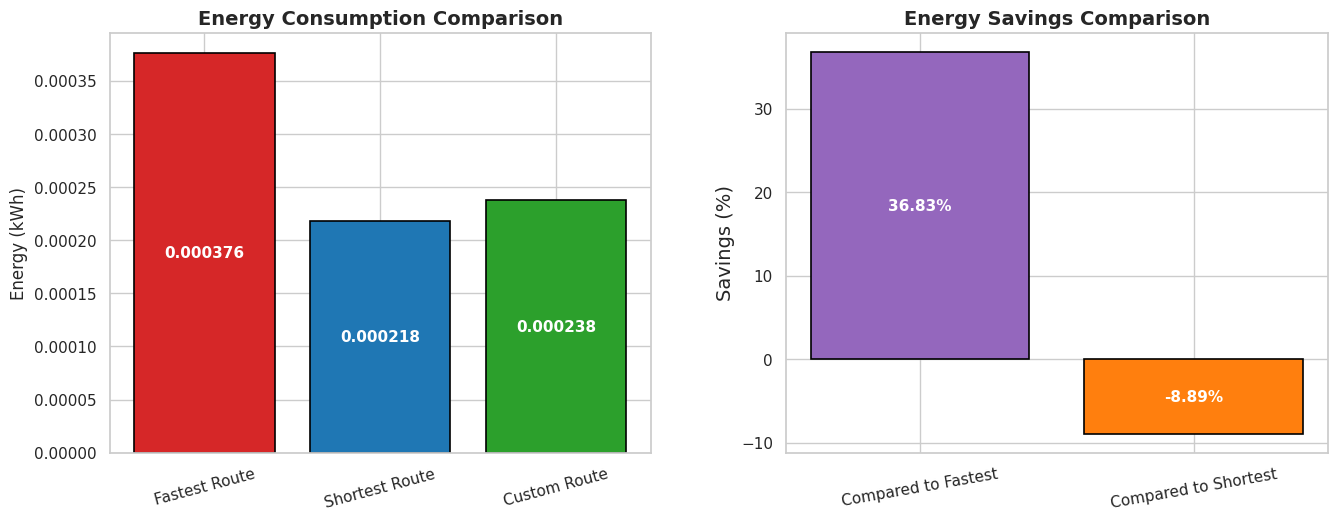

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline


sns.set_theme(style="whitegrid")


energy_labels = ['Fastest Route', 'Shortest Route', 'Custom Route']
energy_values = [
    data['Fastest Route Energy (kWh)'],
    data['Shortest Route Energy (kWh)'],
    data['Custom Route Energy (kWh)']
]


savings_labels = ['Compared to Fastest', 'Compared to Shortest']
savings_values = [
    data['Savings Compared to Fastest (%)'],
    data['Savings Compared to Shortest (%)']
]


energy_colors = ['#d62728', '#1f77b4', '#2ca02c']  # Red, Blue, Green
savings_colors = ['#9467bd', '#ff7f0e']  # Purple, Orange


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting energy consumption
bars1 = axes[0].bar(energy_labels, energy_values, color=energy_colors, edgecolor='black', linewidth=1.2)
axes[0].set_title('Energy Consumption Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Energy (kWh)', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)

# Adding value labels inside bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height * 0.5,  # Position inside the bar
                 f"{height:.6f}", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Plotting savings percentage
bars2 = axes[1].bar(savings_labels, savings_values, color=savings_colors, edgecolor='black', linewidth=1.2)
axes[1].set_title('Energy Savings Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Savings (%)', fontsize=14)
axes[1].tick_params(axis='x', rotation=10)

# Adding value labels inside bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height * 0.5,  # Position inside the bar
                 f"{height:.2f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='white')


plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.15, wspace=0.25)


plt.show()


In [14]:
!pip install flexpolyline

In [15]:
import folium
import flexpolyline

# Decode polyline for routes
fastest_coordinates = flexpolyline.decode(fastest_route["routes"][0]["sections"][0]["polyline"])
shortest_coordinates = flexpolyline.decode(shortest_route["routes"][0]["sections"][0]["polyline"])
# custom_route_coords = flexpolyline.decode(route_sections[0]["polyline"])

# Convert the computed custom route into coordinate pairs
# custom_route_coords = [(lat, lng) for lat, lng in custom_route_coords]

# Create a map centered around the origin
start_lat, start_lng = fastest_coordinates[0]
map_obj = folium.Map(location=[start_lat, start_lng], zoom_start=14)

# Add the fastest route to the map
folium.PolyLine(locations=fastest_coordinates, color="blue", weight=5, tooltip="Fastest Route").add_to(map_obj)

# Add the shortest route to the map
folium.PolyLine(locations=shortest_coordinates, color="orange", weight=10, tooltip="Shortest Route").add_to(map_obj)

# Add the custom route to the map
# folium.PolyLine(locations=custom_route_coords, color="purple", weight=5, tooltip="Custom Route").add_to(map_obj)

# Add markers for origin and destination
folium.Marker(location=fastest_coordinates[0], popup="Origin", icon=folium.Icon(color="green")).add_to(map_obj)

folium.Marker(location=fastest_coordinates[-1], popup="Destination", icon=folium.Icon(color="red")).add_to(map_obj)

# Print the origin and destination
print(f"Origin coordinates: {origin}")
print(f"Destination coordinates: {destination}")

# Display the map
map_obj


Origin coordinates: 45.77031773045832,4.797116290985852
Destination coordinates: 45.76469668270752,4.955347272776582


In [16]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.3 MB/s eta 0:00:00


### Downloading the road network for Lyon,France

In [17]:
import osmnx as ox
import networkx as nx


# 1. Download the road network for Lyon, France (driving network)
G = ox.graph_from_place("Lyon, France", network_type="drive")

# 2. Print the number of nodes and edges in the network
num_nodes = len(G.nodes)
num_edges = len(G.edges)
print("Total number of nodes:", num_nodes)
print("Total number of edges:", num_edges)

Total number of nodes: 4176
Total number of edges: 8253


### Writing all data in a file in the format ["node", "latitude", "longitude"]

In [18]:
import csv
with open('node_coordinates.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write header row
    writer.writerow(["node", "latitude", "longitude"])

    # Write each node's coordinates
    for node, data in G.nodes(data=True):
        writer.writerow([node, data['y'], data['x']])


In [19]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/node_coordinates.csv')

# Print the DataFrame in a tabular format using tabulate
print(tabulate(df, headers='keys', tablefmt='pretty'))

+------+---------------+------------+-----------+
|      |     node      |  latitude  | longitude |
+------+---------------+------------+-----------+
|  0   |   143403.0    | 45.7338265 | 4.8775406 |
|  1   |   143408.0    | 45.734208  | 4.8763392 |
|  2   |   143412.0    | 45.738481  | 4.8628174 |
|  3   |   143413.0    | 45.7378325 | 4.8648442 |
|  4   |   143415.0    | 45.7405718 | 4.8638746 |
|  5   |   143416.0    | 45.7423937 | 4.8648175 |
|  6   |   143417.0    | 45.7434152 | 4.8653524 |
|  7   |   143418.0    |  45.74512  | 4.8662118 |
|  8   |   143421.0    | 45.7445879 | 4.8683205 |
|  9   |   143435.0    | 45.7408693 | 4.862994  |
|  10  |   143439.0    | 45.7435071 | 4.8537112 |
|  11  |   195222.0    | 45.7572235 | 4.836902  |
|  12  |   195228.0    | 45.7592213 | 4.8296142 |
|  13  |   195231.0    | 45.7533116 | 4.8337706 |
|  14  |   195232.0    | 45.7530715 | 4.8339066 |
|  15  |   195234.0    | 45.7512129 | 4.8386402 |
|  16  |   195235.0    | 45.7503096 | 4.8401349 |


## Automating the comparison process for every node

In [20]:
import pandas as pd
import random

def automate_comparison_process(csv_file_path, output_format, num_pairs):
    df = pd.read_csv(csv_file_path)


    if len(df) < 2:
        raise ValueError("The CSV file must contain at least two nodes.")

    simulation_results = []

    for _ in range(num_pairs):
        sample = df.sample(n=2)
        origin_row = sample.iloc[0]
        destination_row = sample.iloc[1]


        origin_str = f"{origin_row['latitude']},{origin_row['longitude']}"
        destination_str = f"{destination_row['latitude']},{destination_row['longitude']}"


        result = compare_routes(origin_str, destination_str, vehicle_params)


        if result is not None:
            simulation_results.append(result)


    save_comparison_results(simulation_results, output_format)

def save_comparison_results(results, output_format):
    if output_format == "csv":
        with open('route_comparison_results.csv', 'w', newline='') as csvfile:
            fieldnames = results[0].keys() if results else []
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(results)
    elif output_format == "json":
        with open('route_comparison_results.json', 'w') as jsonfile:
            json.dump(results, jsonfile, indent=4)
    else:
        print(f"Unsupported output format: {output_format}")

In [30]:
automate_comparison_process('/content/node_coordinates.csv','csv',200)

Comparing routes from Origin: 45.7487628,4.8292093 to Destination: 45.7514354,4.8154953
Comparing routes from Origin: 45.7536622,4.8593929 to Destination: 45.7360216,4.8696307
Comparing routes from Origin: 45.7677968,4.8555169 to Destination: 45.7364052,4.8396842
Comparing routes from Origin: 45.77952,4.8183911 to Destination: 45.783259,4.8076905
Comparing routes from Origin: 45.7359173,4.8523024 to Destination: 45.7288286,4.8228727
Comparing routes from Origin: 45.7535889,4.8715435 to Destination: 45.7520389,4.8554586
Comparing routes from Origin: 45.7451203,4.8420877 to Destination: 45.7340291,4.8627874
Comparing routes from Origin: 45.7725351,4.838088 to Destination: 45.7474128,4.8292752
Comparing routes from Origin: 45.7508135,4.8424315 to Destination: 45.807868,4.837384
Comparing routes from Origin: 45.7952471,4.8250787 to Destination: 45.7490234,4.873164
Comparing routes from Origin: 45.7691709,4.8296067 to Destination: 45.7377981,4.8152033
Comparing routes from Origin: 45.789518

In [22]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Print the DataFrame in a tabular format using tabulate
print(tabulate(df, headers='keys', tablefmt='pretty'))

+-----+----------------------------+-----------------------------+---------------------------+---------------------------------+----------------------------------+
|     | Fastest Route Energy (kWh) | Shortest Route Energy (kWh) | Custom Route Energy (kWh) | Savings Compared to Fastest (%) | Savings Compared to Shortest (%) |
+-----+----------------------------+-----------------------------+---------------------------+---------------------------------+----------------------------------+
|  0  |   8.221936016399411e-05    |    8.221936016399411e-05    |   7.694663304629837e-05   |        6.412999453144364        |        6.412999453144364         |
|  1  |   3.4470736212140154e-05   |    4.103554382686221e-05    |   2.561001871998642e-05   |        25.70504278650452        |        37.59064378910001         |
|  2  |   4.486623187537556e-05    |    4.486623187537556e-05    |  1.7560459221502802e-05   |        60.86040996203938        |        60.86040996203938         |
|  3  |     0.00

### Visualization of the results


Total Average Savings (%): 17.62
Average Savings Compared to Fastest (%): 23.33
Average Savings Compared to Shortest (%): 11.91


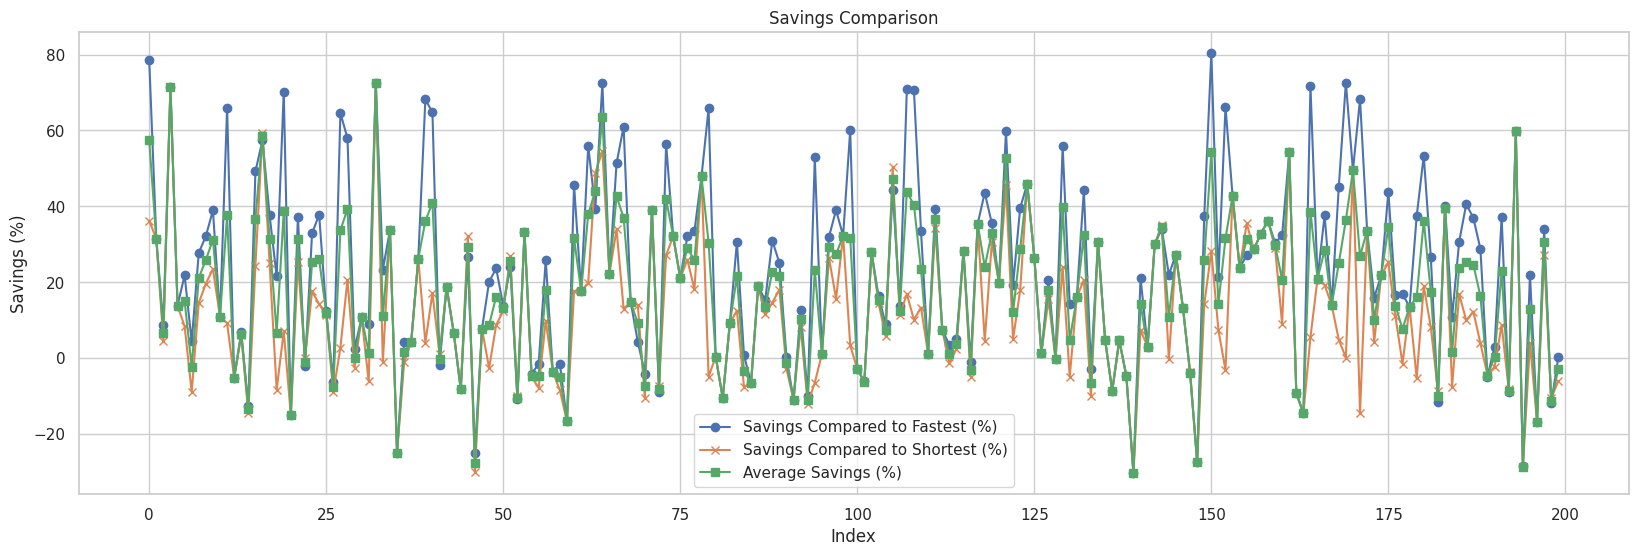

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Calculate the average of the two columns for each row
df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

# Calculate the total average savings
total_average_savings = df['Average Savings (%)'].mean()
average_savings_fastest = df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = df['Savings Compared to Shortest (%)'].mean()



# Print the total average savings
print(f"\nTotal Average Savings (%): {total_average_savings:.2f}")
print(f"Average Savings Compared to Fastest (%): {average_savings_fastest:.2f}")
print(f"Average Savings Compared to Shortest (%): {average_savings_shortest:.2f}")

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o')
plt.plot(df.index, df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x')
plt.plot(df.index, df['Average Savings (%)'], label='Average Savings (%)', marker='s')

# Add titles and labels
plt.title('Savings Comparison')
plt.xlabel('Index')
plt.ylabel('Savings (%)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Visualization with some fault tolerance


Total Average Savings (%): 8.00
Average Savings Compared to Fastest (%): 11.77
Average Savings Compared to Shortest (%): 4.24


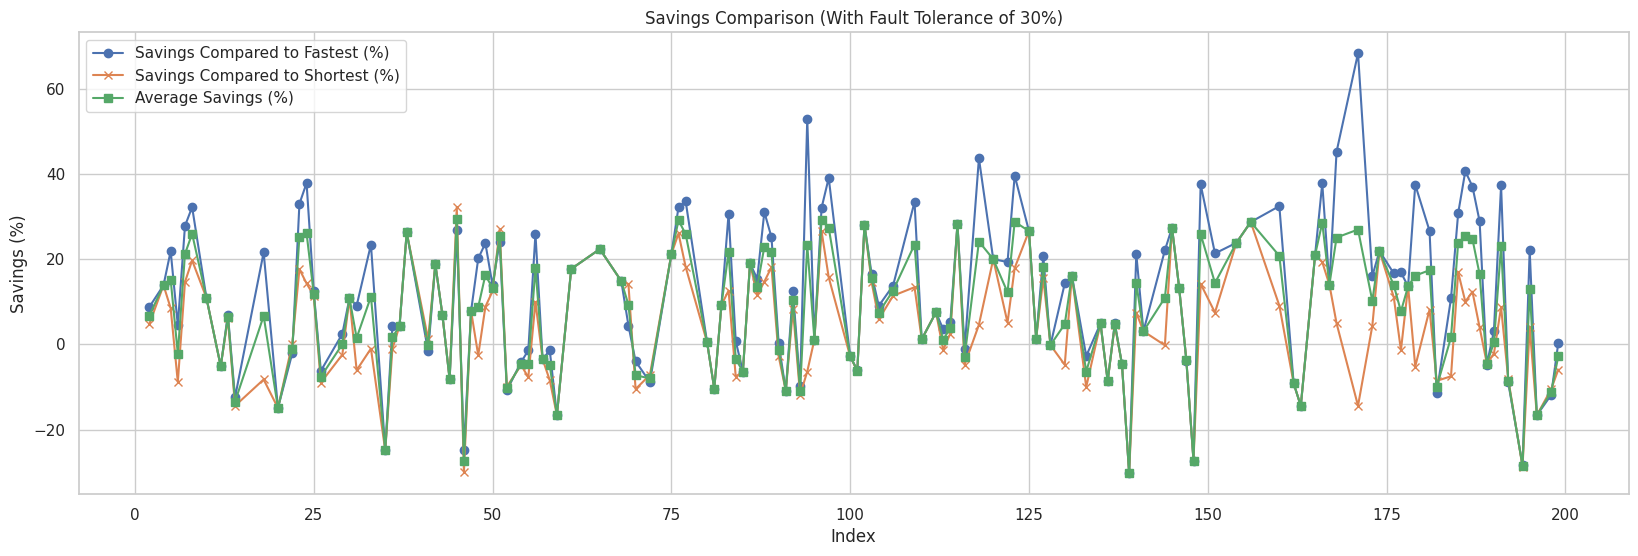

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


FAULT_TOLERANCE_PERCENT = 30


df = pd.read_csv('/content/route_comparison_results.csv')


df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

upper_bound = np.percentile(df['Average Savings (%)'], 100 - FAULT_TOLERANCE_PERCENT)
filtered_df = df[df['Average Savings (%)'] <= upper_bound]


total_average_savings = filtered_df['Average Savings (%)'].mean()
average_savings_fastest = filtered_df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = filtered_df['Savings Compared to Shortest (%)'].mean()


print(f"\nTotal Average Savings (%): {total_average_savings:.2f}")
print(f"Average Savings Compared to Fastest (%): {average_savings_fastest:.2f}")
print(f"Average Savings Compared to Shortest (%): {average_savings_shortest:.2f}")

plt.figure(figsize=(20, 6))
plt.plot(filtered_df.index, filtered_df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o')
plt.plot(filtered_df.index, filtered_df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x')
plt.plot(filtered_df.index, filtered_df['Average Savings (%)'], label='Average Savings (%)', marker='s')


plt.title(f'Savings Comparison (With Fault Tolerance of {FAULT_TOLERANCE_PERCENT}%)')
plt.xlabel('Index')
plt.ylabel('Savings (%)')
plt.legend()
plt.grid(True)

plt.show()



Total Average Savings (%): 17.62
Average Savings Compared to Fastest (%): 23.33
Average Savings Compared to Shortest (%): 11.91


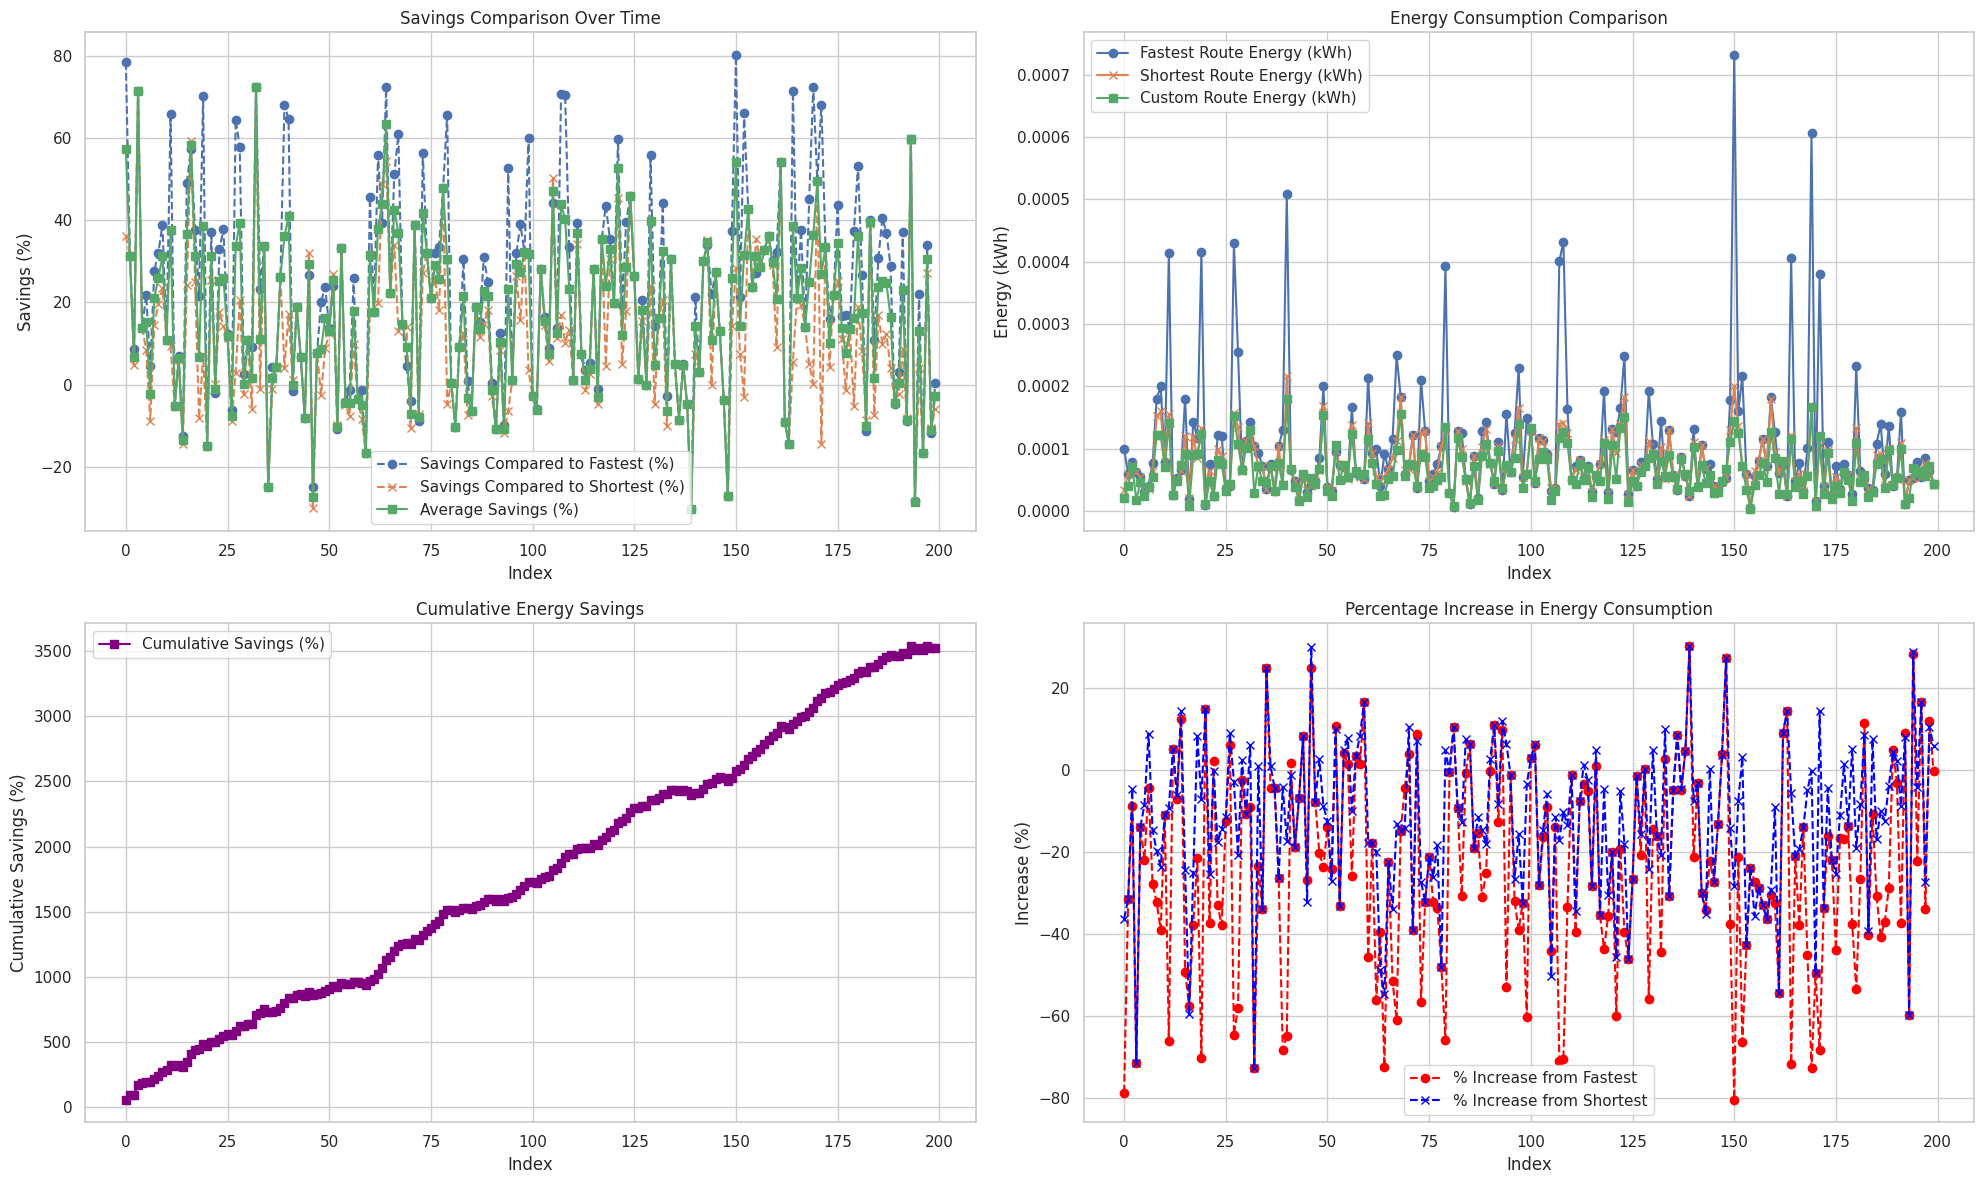

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Calculate new metrics
df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

# Total averages
total_average_savings = df['Average Savings (%)'].mean()
average_savings_fastest = df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = df['Savings Compared to Shortest (%)'].mean()

# Compute cumulative savings (total impact over time)
df['Cumulative Savings (%)'] = df['Average Savings (%)'].cumsum()

# Compute relative percentage increase/decrease in energy consumption
df['% Increase from Fastest'] = ((df['Custom Route Energy (kWh)'] - df['Fastest Route Energy (kWh)']) / df['Fastest Route Energy (kWh)']) * 100
df['% Increase from Shortest'] = ((df['Custom Route Energy (kWh)'] - df['Shortest Route Energy (kWh)']) / df['Shortest Route Energy (kWh)']) * 100

# Print the total average savings
print(f"\nTotal Average Savings (%): {total_average_savings:.2f}")
print(f"Average Savings Compared to Fastest (%): {average_savings_fastest:.2f}")
print(f"Average Savings Compared to Shortest (%): {average_savings_shortest:.2f}")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Savings Comparison Over Time
axes[0, 0].plot(df.index, df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o', linestyle='--')
axes[0, 0].plot(df.index, df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x', linestyle='--')
axes[0, 0].plot(df.index, df['Average Savings (%)'], label='Average Savings (%)', marker='s', linestyle='-')
axes[0, 0].set_title('Savings Comparison Over Time')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Savings (%)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Energy Consumption Comparison
axes[0, 1].plot(df.index, df['Fastest Route Energy (kWh)'], label='Fastest Route Energy (kWh)', marker='o')
axes[0, 1].plot(df.index, df['Shortest Route Energy (kWh)'], label='Shortest Route Energy (kWh)', marker='x')
axes[0, 1].plot(df.index, df['Custom Route Energy (kWh)'], label='Custom Route Energy (kWh)', marker='s')
axes[0, 1].set_title('Energy Consumption Comparison')
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Energy (kWh)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Cumulative Savings Over Time
axes[1, 0].plot(df.index, df['Cumulative Savings (%)'], label='Cumulative Savings (%)', marker='s', color='purple')
axes[1, 0].set_title('Cumulative Energy Savings')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Cumulative Savings (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Percentage Increase in Energy Consumption
axes[1, 1].plot(df.index, df['% Increase from Fastest'], label='% Increase from Fastest', marker='o', linestyle='--', color='red')
axes[1, 1].plot(df.index, df['% Increase from Shortest'], label='% Increase from Shortest', marker='x', linestyle='--', color='blue')
axes[1, 1].set_title('Percentage Increase in Energy Consumption')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Increase (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()
